
# ICRA Tutorial 4, Contradictory Prior Data

**API Version: JuliaLang Caesar.jl**

## Application: Beyond "Brute-Force" Automation while Retaining Prior Knowledge

Conventional manufacturing and warehouse automation technologies operate via "brute force" or "playback" control strategies where robot operations follow a very narrow preprogrammed path.  One of the major challenges in AI development for manufacturing and warehouse applications is to make the high value robotic equipment more flexible/reconfigurable so that a broader spectrum of tasks can be automated.  

One of the key challenges to expanding the automation software capabilities is striking the balance between programming the robot with human readible prior information about the task as well as letting the robotic automation handle more of the fine grain numerical operations relating to the task at hand.  The figure below shows a motivational example where prior knowledge---i.e. the corners of a rectangle and door opening---is to be used for robotic mapping operations.

![Tutorial 4 Room Prior](../../static/icra-4/room-prior.png)

The figure above illustrates some robotic equipment (a.k.a. the robot) which must be localized relative to a known rectangular shape.  For simplicity, we introduce the door orientation as the only one ambiguity which must be mapped by the robot -- i.e. we know there is a door, but have not yet verified the hinging orientation.

The challenge of this tutorial is localizing and mapping the robot relative to the object as efficiently as possible, and have the solution be robust to possibly contradictory prior data.  For the sake of illustration, we simplify the possible contradiction to the door orientation only, and invite the interested reader to see the [NavAbility Construction Application example](https://www.navability.io/applications/construction/) and associated publications for a more elaborate discussion on navigation-affordances.

### Prior (Contradictory) Data

This tutorial will demonstrate through a simplified example how prior (contradictory) data can be leveraged in a localization and mapping solution using factor graphs.  We want to pre-load our robotic system with some basic information about the environment in which it will be operating so that it can more easily resolve it's position and navigate around.

#### Room with a Door

Prior info:
- A rectangular room with the 4 corners as defining known navigation affordances,
- A door which should* be hinged on the left side as contradictory affordance

## Import Packages

The first step load all the necessary packages, as listed in code blocks hereafter.  The following commented code block is only necessary if your environment does not have the necessary packages installed for whatever reason (uncomment and run once if package are not installed).

In [ ]:
# # install if necessary
# import Pkg; [Pkg.add(s) for s in ["RoME";"RoMEPlotting"; "GraphPlot"; "Logging"]];

For notebooks it's useful to reduce the amount of text printouts:

In [1]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn);

And then the actual solver and visualization packaged used in this tutorial:

In [ ]:
using RoME
using GraphPlot
using RoMEPlotting

As the last code loading, we have a few predefined plotting functions to help with the visualization flow of this tutorial.  These plotting functions will be used multiple times below:

In [3]:
# helper plotting functions
function plotRoom(fg)
  pl = plotSLAM2DLandmarks(fg, drawPoints=false, regexLandmark=r"c\d", drawContour=false, drawEllipse=true)
  pl2 = plotSLAM2DLandmarks(fg, drawPoints=false, regexLandmark=r"door_", drawContour=false, drawEllipse=true)
  union!(pl.layers, pl2.layers)
  pl.coord = Gadfly.Coord.Cartesian(xmin=-2,xmax=22,ymin=-2,ymax=12)
  pl
end

function plotTraj(fg, lbls=sortDFG(ls(fg, r"x\d")))
  pl = plotBelief(fg, lbls, dims=[1;2], c=RoMEPlotting.getColorsByLength(length(lbls)), levels=3)
  pl.coord = Gadfly.Coord.Cartesian(xmin=-2,xmax=22,ymin=-2,ymax=12)
  pl
end

function plotRoomTraj(fg)
  pl = plotTraj(fg)
  pl2 = plotRoom(fg)
  union!(pl.layers, pl2.layers)
  pl
end

function printHingedDoor(ornt, str="resolved")
  if abs(ornt) < pi/2
    println("Door affordance $str as left hinged")
  else
    println("Door affordance $str as right hinged")
  end
end

printHingedDoor (generic function with 2 methods)

## Build a Multi-hypothesis Factor Graph

We start with an empty factor graph object, which is created with default solver parameters.

In [ ]:
fg = initfg()

prior_distr= diagm([0.1, 0.1, 0.01].^2)
dual_distr= diagm([1, 1, sqrt(pi)].^2)

### Loading Known Prior Data

Next, add to the factor graph the four corner prior knowledge about the room, namely `c0`, `c1`, `c2`, `c3`, each with their expected location in the world via `PriorPose2` unary factor:

In [ ]:
addVariable!(fg, :c0, Pose2)
addFactor!(fg, [:c0], PriorPose2(MvNormal([0.,0, 0], prior_distr)))

addVariable!(fg, :c1, Pose2)
addFactor!(fg, [:c1], PriorPose2(MvNormal([20.,0, pi/2], prior_distr)))

addVariable!(fg, :c2, Pose2)
addFactor!(fg, [:c2], PriorPose2(MvNormal([20.,10, pi], prior_distr)))

addVariable!(fg, :c3, Pose2)
addFactor!(fg, [:c3], PriorPose2(MvNormal([0.,10, -pi/2], prior_distr)))

Also add the prior information regarding the door, and note for this simplified tutorial is using two affordance variables.  Two variables is part of the _affordance-duality_ construct where contradictions between prior known and ultimately discovered data can manifest in either the prior or dual variables, respectfully:

In [ ]:
addVariable!(fg, :door_prior, Pose2)
addFactor!(fg, [:door_prior], PriorPose2(MvNormal([20.,4, 0], prior_distr)))

addVariable!(fg, :door_dual, Pose2)
addFactor!(fg, [:door_dual], PriorPose2(MvNormal([20.,4, pi], dual_distr)))

### Solving the Room-only Graph

Let's make sure our prior data makes sense by solving the factor graph with the available data:

In [ ]:
solveGraph!(fg);

We confirm the prior data is correctly loaded by plotting room with earlier utility function, which shows the numerical solution now contained in the graph:

[0.01 -0.0; -0.0 0.01]
[0.011 0.001; 0.001 0.009]
[0.009 0.0; 0.0 0.011]
[0.01 0.001; 0.001 0.01]
[1.004 0.02; 0.02 0.909]
[0.013 0.001; 0.001 0.012]


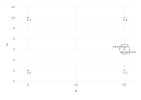

In [34]:
plotRoom(fg)

The plot shows the four corners as a rectangle between `(0,0)` and `(20,10)`, as well as a door at `(20,4)`.  We also confirm the door prior data orientation which to the best of our current knowledge is **left hinged**:

In [35]:
printHingedDoor(getPPE(fg, :door_prior).suggested[3], "prior")

Door affordance prior as left hinged


### The Room-only Graph Structure

The basic room structure in the factor graph is also of interest.  Let's go ahead and look at what the graph structure looks like:

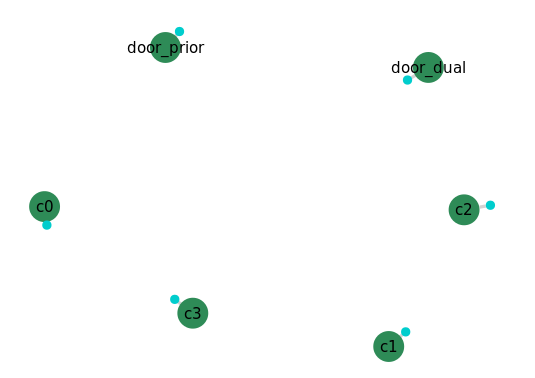

In [36]:
DFG.plotDFG(fg)

The graph plot above shows the simple factor graph so far, where four corner and dual door variables each have a prior factor.  We are now ready to introduce new robotic measurements into the factor graph.

## Add Robotic Measurements (`multihypo=`)

We would like to localize our robotic system relative to the available prior data above.  The first thing the robot does is measure one of the corners relative to it's own position (i.e. **a relative, not global, measurement**).  Since we do not know which of the corners this measurement relates to, we will use the `multihypo=` keyword with equal `1/4` probability to each of the four known corners:

In [ ]:
addVariable!(fg, :x0, Pose2)
addFactor!(
  fg, 
  [:x0, :c0, :c1, :c2, :c3], 
  Pose2Pose2(MvNormal([-2, -2, 0.], diagm([0.5, 0.5, 0.05].^2))), 
  multihypo=[1.0, 0.25, 0.25, 0.25, 0.25]
)

Above we first added a new robot 'pose' variable `x0`.  We then added a relative `Pose2Pose2` factor which represents a rigid transform between the robot and the measured corner.  Note, the measurement is local to the robot (i.e. not a global metrology-type measurement).  Also note that the `Pose2Pose2` factor is usually binary between two variables but now, with the `multihypo=` keyword, is associated with five variables.  The first is the robot pose `x0` with `100%` certainty, while the next four corner affordance variables have fractional association certainty of `25%` each4.

Let's look to see how this factor is represented in the factor graph visualization:

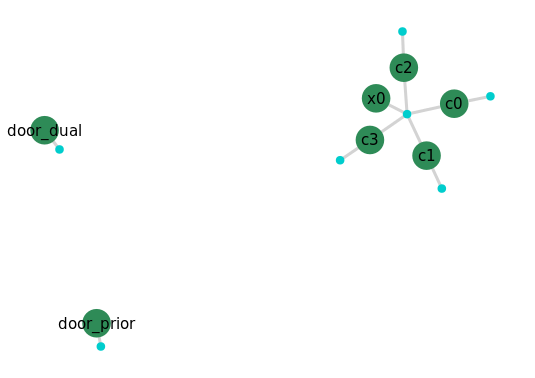

In [38]:
DFG.plotDFG(fg)

### Solving a Multi-hypothesis Factor Graph

The Caesar.jl solver is purpose built to solve non-Gaussian factor graphs, and therefore we just call for a solve on the graph object as before:

In [ ]:
solveGraph!(fg);

Let's recap what the factor represents and what we are expecting to see.  We know there are four corners to a room and we have one relative measurement to a corner.  Therefore, the robot should be relatively positioned to one of the four known corners -- i.e. we expect to see a multi-modal posterior belief estimate on the robot pose `x0`.  Let's plot the numerical results to see:

[0.013 0.001; 0.001 0.009]
[0.013 -0.003; -0.003 0.012]
[0.012 0.003; 0.003 0.01]
[0.011 -0.001; -0.001 0.012]
[1.016 0.012; 0.012 0.855]
[0.011 -0.0; -0.0 0.013]


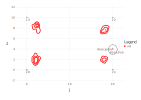

In [40]:
plotRoomTraj(fg)

As predicted, there are four separate modes in the posterior marginal estimate of `x0`, one nearby each of the four known corners of the room.  Note that each of these modes also have a marginal belief over the orientation of the robot which corresponds to the relative transform to the measured corner.

The critcal point here is that even though the factor graph does not have a unimodal solution, we are able to perform a solve on the graph and recover the correct non-Gaussian marginal posterior result.

## Robot Moves to Position `x1`

The next step towards mapping while localizating the robot relative to prior data is moving the robot and making more measurements.  To get to the second position, we move the robot forward by `2` units and rotate clockwise (around positive `z`) by `90deg`; this transform is captured in another rigid transform `Pose2Pose2` factor to a new variable `x1`.  Once at `x1` the robot makes a second corner measurement for which we again don't know the association:

In [ ]:
addVariable!(fg, :x1, Pose2)
addFactor!(fg, [:x0, :x1], Pose2Pose2(MvNormal([4, 0, pi/2], diagm([0.5, 0.5, 0.05].^2))), nullhypo=0.5)

addFactor!(fg, [:x1, :c0, :c1, :c2, :c3], Pose2Pose2(MvNormal([-2, -4, 0], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1.0, 0.25, 0.25, 0.25, 0.25])

Note, that even though we know this second corner measured is a different corner than what we measured first, we lazily added the new corner measurement again as a four way equal `multihypo=` uncertainty.  We help the solver a little bit with this by allowed a bit more freedom in the solution (i.e. an additional source of entropy), but also stating that the interpose measurement might not be wholly correct -- and we do this by including `nullhypo=0.5`.

We are therefore giving the factor graph solver less information than we actually have available.  Let's solve the graph again and see what it finds: 

In [ ]:
solveGraph!(fg);

[0.015 -0.0; -0.0 0.013]
[0.012 -0.001; -0.001 0.012]
[0.011 -0.0; -0.0 0.011]
[0.012 -0.0; -0.0 0.01]
[0.827 0.06; 0.06 0.854]
[0.011 0.002; 0.002 0.01]


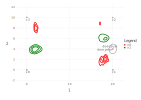

In [43]:
plotRoomTraj(fg)

You should see the marginal posterior belief for pose `x0` has reduced to two of the previous four modes, and the new `x1` pose also having two associated modes from the relative factor.  Therefore, the factor graph solution currently has two likely hypotheses contained within the numerical solution:
- Mode 1 starts with `x0` at `(2,8)` down to `x1` at `(2,4)` in affordance (rectangle coordinates), or
- Mode 2 starts with `x0` at `(18,2)` up to `x1` at `(18,6)`.


## Robot Moves to Postion `x2`

We move the robot forward by `16` units until a new boundary is detected, and add the new pose variable `x2`.  A corner is again measured, and we again lazily add the `Pose2Pose2` measurement to the new corner as a `multihypo=` factor at `1/4` association probability to any of the four prior known corners.  Strictly speaking, the factor graph builder can already deduce that the new corner measurement is likely only one of two corners from the prior data, however, the point of this tutorial is to show that the factor graph builder's job is being simplifiedy by a more capable back-end factor graph solver.  So the new corner measurement factor is added in a lazy fashion:

In [ ]:
addVariable!(fg, :x2, Pose2)
addFactor!(fg, [:x1, :x2], Pose2Pose2(MvNormal([16, 0, 0], diagm([0.5, 0.5, 0.05].^2))))

addFactor!(fg, [:x2, :c0, :c1, :c2, :c3], Pose2Pose2(MvNormal([2, -4, pi/2], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1.0, 0.25, 0.25, 0.25, 0.25])

Before solving the graph, let's first take a look at it's current structure:

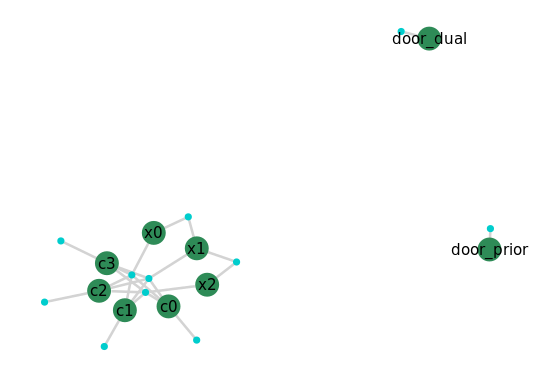

In [51]:
DFG.plotDFG(fg)

We see three corner measurements that could each be associated with any of the four prior corner affordances.  We also see the three new poses `(x0,x1,x2)` connected by two relative factors.  The dual door affordance variables have not yet been sighted by the robot and remain with priors factors only.

We proceed to solve the graph again and look at the numerical results:

In [ ]:
solveGraph!(fg);

[0.011 -0.001; -0.001 0.011]
[0.011 0.001; 0.001 0.01]
[0.012 -0.002; -0.002 0.018]
[0.014 -0.003; -0.003 0.009]
[0.753 -0.011; -0.011 1.146]
[0.01 -0.001; -0.001 0.01]


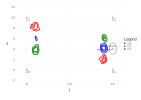

In [47]:
plotRoomTraj(fg)

We find there are still two modes in each of the posterior marginal beliefs on the three poses `(x0,x1,x2)` which represent two hypotheses of how the robot is moving relative to the overall rectangular affordance.

## The Robot Senses the Door!

The last measurement made by the robot is to the door affordance, which is sensed to be `2` units ahead of the robot and to have a relative orientation to pose `x2` of `180deg`.  

### Door as Navigation-Affordance with Duality

We will use the factor graph to extract two crucial pieces of information from the door measurement.  To do this we will use the navigation-affordance duality construct where the robot local door measurement is introduced to the factor graph using the `multihypo=` mechanism with `50/50%` likelihood between the `door_prior` and `door_dual` variables:

In [ ]:
addFactor!(fg, [:x2, :door_prior, :door_dual], Pose2Pose2(MvNormal([2.0, 0, pi], diagm([0.5, 0.5, 0.05].^2))), multihypo=[1,0.5,0.5])

This simplified duality example illustates an important point, that even though we have some confidence about where the door is expected to be on the rectangular shape we do not have to be right.  In this simplified example, we take a weaker prior on the position of `door_dual` but assume no direction of the door.  Our prior assumptions about the door position and orientation are tied with tight prior on the `door_prior` variable.  

In a moment, we will show that this prior information is actually contradictory to what is being measured by the robot.  The navigation-affordance with duality construct allows us buidl a factor graph with confidence, in spite of unknow contradictions that arise from the measured data.  A more elaborate example and use of navigation-affordances with duality is described in the [NavAbility Construction example](https://www.navability.io/applications/construction/) and linked publication.

The door orientation measurement made by the robot is a local detection on which way the door is hinged, and was included in the factor above with `mean=(2,0,pi)`.  Let's solve the factor graph and see if any data contradictions are found and how they impact the solver performance:

In [ ]:
solveGraph!(fg);

[0.011 0.001; 0.001 0.014]
[0.011 0.002; 0.002 0.015]
[0.008 -0.002; -0.002 0.013]
[0.009 -0.0; -0.0 0.009]
[0.723 -0.098; -0.098 0.887]
[0.012 -0.001; -0.001 0.015]


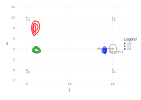

In [61]:
plotRoomTraj(fg)

Only one trajectory mode/hypothesis remains!

## Resolved Correct Localization/Mapping Hypothesis

The plot above shows a single hypothesis for pose locations `(x0,x1,x2)` of how the robot moved relative to the rectangular object.  **This resolution was extracted by making LOCAL measurements only and by leveraging prior data about the object**.  Resolving the robot position relative to the object did not require any global metrology measurements, and is furthermore able to resolve discrepancies between the prior anticipated navigation affordance models and the measured data.  Let's look at the `door` variables more closely... 

## Resolved Door Orientation

The solver also resolved the correct `:door_` orientation from local robot measurement data.  We can see which door orientation was was found during measurement when comparing both the `prior` and `dual` variables.  We use a small helper function to interpret the results:

In [62]:
printHingedDoor(getPPE(fg, :door_prior).suggested[3],"prior")
printHingedDoor(getPPE(fg, :door_dual).suggested[3])

Door affordance prior as left hinged
Door affordance resolved as right hinged


This indicates that the door affordance **prior information is contradictory** but the factor graph solution was correctly resolved during non-Gaussian inference to a stable, unimodal solution.  

The door orientation example is a trivial case to help connnect the multi-hypothesis factors to navigation-affordances.  Note that navigation affordances are a much deeper topic described in more detail in the [NavAbility Construction example](https://www.navability.io/applications/construction/) and linked publication. 

### Final Graph Structure

Let's look at the final factor graph structure a last time, where we note that all variables are now interconnected by a series of prior and new measurement data.  Building the factor graph was pretty easy, and the factor graph solver cranked through the numbers to untangle a multi-hypothesis mapping while localizing problem.

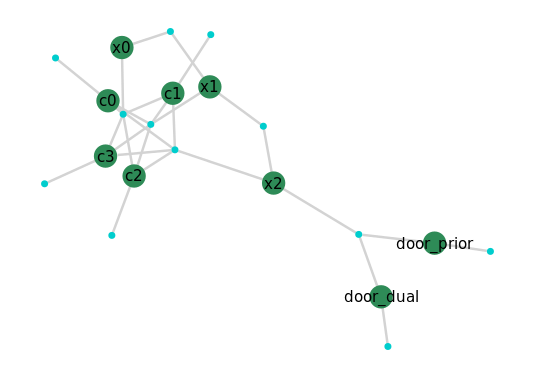

In [60]:
DFG.plotDFG(fg)

This concludes the tutorial on multi-hypothesis factors.

## Conclusion and Next Steps

### Navigation-Affordances

This example shows how prior (possibly contradictor) data can be incorporated into a localization and mapping solution, and how prior (contradictory) data can be combined with new local/relative measurement information in a human readible factor graph notation.  The value of having prior data for localization and mapping can be enormous, yet the risk of inducing unwanted errors due to contradictory data in the final problem are equally large -- this tutorial shows how NavAbility's method of leveraging contradictory prior data as well as detecting discrepancies between "as-designed" and "as-built" artifacts.

This tutorial shows how to use non-Gaussian inference to resolve the duality problem between measurement errors and contradictory data models by using the multi-hypothesis features in a factor graph solution.  This tutorial is in 2D on a XY-plane, and can readily be expanded to 3D or much more elaborate navigation-affordance constructs. 

This tutorial is applicable to human operated surveyor/metrology measurement equipment; and can readily be expanded for use with more autonomous mobile robotic equipment.  This tutorial shows that the robot measurement locations are not known in advance, and that the relative translation between measurement locations can be combined with prior (possible contradictory) data for mapping and verification.

This tutorial together with more elaborate NavAbility publications show how known markers/features can readily be used for "as-designed" prior inforation.  For example a CAD model or floor plan of a construction.

### Multi-hypothesis for Data Association

This example shows one of four possible mechanisms by which non-Gaussian behavior can be introduced to a factor graph system.  To simplify the tutorial, the measurements are assumed to be purely Gaussian and non-Guassian behavior is introduced through the multi-hypothesis data association mechanism.  Other mechanisms shown in other examples can readily be added to this tutorial for a more intricate system.

The multi-hypothesis mechanism used in this tutorial also shows how the user can introduce discrete data association uncertainty into the estimation problem at the factor graph level.  This approach is immediately applicable to loop-closures in SLAM, as was [previously published -- see Caesar.jl references here](https://juliarobotics.org/Caesar.jl/latest/refs/literature/).


### Contrast to Non-Gaussian Measurements

Pay close attention to to the difference from Tutorial 2 where uncertainty about ambiguous data was marginalized into the measurements that was used to generate the factors.  There is a major difference between non-Gaussian measurements in one factor vs. a unimodal factor with discrete uncertainty in association to variables -- the crux of the matter is marginalization before or during inference.  

The NavAbility platform and Caesar.jl solver allow the user to mix-and-match the four identified sources of non-Gaussian behavior in a single factor graph.  This tutorial demonstrated one of those features using mapping of a navigation-affordance as the driving example.

### On-Manifold Operations

All the features describe above are computed on-manifold.  For more information, see the [Using Manifolds page in the Caesar.jl solver documentation](https://juliarobotics.org/Caesar.jl/latest/concepts/using_manifolds/).

### Solving the Graph via the Bayes Tree

The Caesar.jl solver uses the Bayes tree find the numerical solution for the factor graphs it's solving.  The open code has numerous features such as clique recycling a more.  To learn more about [the Bayes tree, see the Caesar.jl documentation page here](https://juliarobotics.org/Caesar.jl/latest/principles/bayestreePrinciples/).